In [1]:
import os
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader
from torchvision import transforms
from tqdm import tqdm
import torch.nn as nn
import torchvision.models as models
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [2]:
import pickle
BASE_PATH = "/kaggle/input/cifar-wec/cifar-10-batches-py"

train_data = []
train_label = []

def unpickle(file):
    with open(file ,'rb') as f:
        data_dict = pickle.load(f , encoding = 'bytes')
    return data_dict
        
for i in range(1,6):
    batch_path = os.path.join(BASE_PATH , f"data_batch_{i}" )
    batch = unpickle(batch_path)
    train_data.append(batch[b'data'])
    train_label.extend(batch[b'labels'])

X_train = np.vstack(train_data)      
y_train = np.array(train_label)     

In [3]:
test_data = []
test_label = []

test_path = os.path.join(BASE_PATH , 'test_batch')
test_batch = unpickle(test_path)
test_data.append(batch[b'data'])
test_label.extend(batch[b'labels'])

y_test = np.array(test_label)    

In [4]:
CIFAR_MEAN = (0.4914, 0.4822, 0.4465)
CIFAR_STD  = (0.2470, 0.2435, 0.2616)

train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),         
    transforms.RandomHorizontalFlip(p=0.5),        
    transforms.ColorJitter(brightness=0.1, contrast=0.1,
                           saturation=0.1, hue=0.1),
    transforms.RandomPerspective(distortion_scale=0.2, p=0.5),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(CIFAR_MEAN, CIFAR_STD)
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(CIFAR_MEAN, CIFAR_STD)
])

In [5]:
def cifar_flat_to_pil(img_flat):
    r = img_flat[0:1024].reshape(32,32)
    g = img_flat[1024:2048].reshape(32,32)
    b = img_flat[2048:3072].reshape(32,32)
    img = np.stack([r,g,b], axis=2).astype('uint8')
    pil_img = Image.fromarray(img).convert("RGB")
    return pil_img

In [6]:
from PIL import Image
def cifar_dataset_to_pil(flat_images):
    pil_images = []
    for img_flat in flat_images:
        pil_img = cifar_flat_to_pil(img_flat)  # pass the array directly
        pil_images.append(pil_img)
    return pil_images

train_data_flat = np.vstack(train_data)
test_data_flat = np.vstack(test_data)   

train_images = cifar_dataset_to_pil(train_data_flat)
test_images = cifar_dataset_to_pil(test_data_flat)

In [7]:
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import torch
import multiprocessing

class CIFAR10_dataset(Dataset):
    def __init__(self, images, labels=None, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform
        self.has_labels = labels is not None
        print(f"\nLoading CIFAR10 Dataset... Total Len: {len(images)} | Labeled: {self.has_labels}\n{'-'*50}")

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx]
        if self.transform:
            img = self.transform(img)
        if self.has_labels:
            label = torch.tensor(self.labels[idx], dtype=torch.long)
            return {"img": img, "label": label}
        else:
            return {"img": img}


train_images_split, val_images, y_train_split, y_val = train_test_split(
    train_images, y_train,
    test_size=0.2,         
    random_state=42,       
    stratify=y_train        
)

In [8]:
train_dataset = CIFAR10_dataset(train_images_split, y_train_split, transform=train_transform)
val_dataset = CIFAR10_dataset(val_images, y_val, transform=test_transform)
test_dataset = CIFAR10_dataset(test_images, labels=None, transform=test_transform)

train_loader = DataLoader(
    train_dataset,
    batch_size=128,
    shuffle=True,
    num_workers=multiprocessing.cpu_count(),
    pin_memory=True,
    persistent_workers=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=128,
    shuffle=False,
    num_workers=multiprocessing.cpu_count(),
    pin_memory=True,
    persistent_workers=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=128,
    shuffle=False,
    num_workers=multiprocessing.cpu_count(),
    pin_memory=True,
    persistent_workers=True
)


Loading CIFAR10 Dataset... Total Len: 40000 | Labeled: True
--------------------------------------------------

Loading CIFAR10 Dataset... Total Len: 10000 | Labeled: True
--------------------------------------------------

Loading CIFAR10 Dataset... Total Len: 10000 | Labeled: False
--------------------------------------------------


In [9]:
def create_model(model_name, num_classes=10):
    if model_name == 'ResNet18':
        model = models.resnet18(pretrained=True)
        model.fc = nn.Linear(model.fc.in_features, num_classes)
    elif model_name == 'EfficientNet-B0':
        model = models.efficientnet_b0(pretrained=True)
        model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
    elif model_name == 'VGG16':
        model = models.vgg16(pretrained=True)
        model.classifier[6] = nn.Linear(4096, num_classes)
    
    return model

In [10]:
model_configs = {
    "ResNet18": {
        "optimizer": "SGD",
        "lr": 0.01,
        "momentum": 0.9,
        "weight_decay": 5e-4
    },
    "EfficientNet-B0": {
        "optimizer": "AdamW",
        "lr": 0.001,
        "weight_decay": 1e-4
    },
    "VGG16": {
        "optimizer": "SGD",
        "lr": 0.0005,
        "momentum": 0.9,
        "weight_decay": 5e-4
    }
}


In [11]:
import os

os.makedirs("/kaggle/working/model_results", exist_ok=True)

In [12]:
def train_model(model, model_name, train_loader, val_loader, epochs=50):
    print(f"Training {model_name}")
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    
    config = model_configs[model_name]
    if config['optimizer'] == 'SGD':
        optimizer = torch.optim.SGD(model.parameters(), lr=config['lr'], 
                                  weight_decay=1e-4, momentum=config.get('momentum', 0.8))
    else:
        optimizer = torch.optim.Adam(model.parameters(), lr=config['lr'], 
                                   weight_decay=1e-4)
    
    criterion = nn.CrossEntropyLoss()
    lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=5, min_lr=0.00001)
    
    history = {
        'train_loss': [], 'val_loss': [],
        'train_acc': [], 'val_acc': [],
        'val_precision': [], 'val_recall': [], 'val_f1': []
    }
    
    best_val_acc = 0
    best_model_path = f"/kaggle/working/model_results/best_{model_name.replace('-', '_')}.pth"
    
    for epoch in range(epochs):
        
        model.train()
        train_loss, train_correct = 0, 0
        all_train_preds, all_train_labels = [], []
        
        for batch in tqdm(train_loader, desc=f'{model_name} - Epoch {epoch+1}/{epochs} [Train]'):
            images, labels = batch["img"].to(device), batch["label"].to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item() * images.size(0)
            preds = outputs.argmax(1)
            train_correct += (preds == labels).sum().item()
            
            all_train_preds.extend(preds.cpu().numpy())
            all_train_labels.extend(labels.cpu().numpy())
        
        train_loss = train_loss / len(train_loader.dataset)
        train_acc = 100. * train_correct / len(train_loader.dataset)
        
        # Validation
        model.eval()
        val_loss, val_correct = 0, 0
        all_val_preds, all_val_labels, all_val_probs = [], [], []
        
        with torch.no_grad():
            for batch in tqdm(val_loader, desc=f'{model_name} - Epoch {epoch+1}/{epochs} [Val]'):
                images, labels = batch["img"].to(device), batch["label"].to(device)
                
                outputs = model(images)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item() * images.size(0)
                preds = outputs.argmax(1)
                val_correct += (preds == labels).sum().item()
                
                probs = torch.softmax(outputs, dim=1)
                
                all_val_preds.extend(preds.cpu().numpy())
                all_val_labels.extend(labels.cpu().numpy())
                all_val_probs.extend(probs.cpu().numpy())
        
        val_loss = val_loss / len(val_loader.dataset)
        val_acc = 100. * val_correct / len(val_loader.dataset)
        
        # Compute metrics
        from sklearn.metrics import precision_score, recall_score, f1_score, classification_report, confusion_matrix
        
        val_precision = precision_score(all_val_labels, all_val_preds, average='macro', zero_division=0)
        val_recall = recall_score(all_val_labels, all_val_preds, average='macro', zero_division=0)
        val_f1 = f1_score(all_val_labels, all_val_preds, average='macro', zero_division=0)
        
        # Store history
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)
        history['val_precision'].append(val_precision)
        history['val_recall'].append(val_recall)
        history['val_f1'].append(val_f1)
        
        print(f"\n{model_name} - Epoch {epoch+1} Results:")
        print(f"   Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
        print(f"   Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")
        print(f"   Val Precision: {val_precision:.4f} | Recall: {val_recall:.4f} | F1: {val_f1:.4f}")
        print(f"   LR: {optimizer.param_groups[0]['lr']:.6f}")
        
        # ===== Save best model and calibration data =====
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), best_model_path)
            print(f"NEW BEST MODEL! Val Acc: {val_acc:.2f}%")
            
            # Create model-specific directory
            model_dir = f"/kaggle/working/model_results/{model_name}"
            os.makedirs(model_dir, exist_ok=True)
            
            # Convert to numpy arrays
            all_val_labels = np.array(all_val_labels)
            all_val_preds = np.array(all_val_preds)
            all_val_probs = np.array(all_val_probs)
            all_val_confidence = np.max(all_val_probs, axis=1)
            
            # ===== Save calibration data =====
            np.save(f'{model_dir}/{model_name}_val_probs.npy', all_val_probs)
            np.save(f'{model_dir}/{model_name}_val_preds.npy', all_val_preds)
            np.save(f'{model_dir}/{model_name}_val_labels.npy', all_val_labels)
            np.save(f'{model_dir}/{model_name}_val_confidence.npy', all_val_confidence)
            
            # ===== Save classification report =====
            class_names = ['airplane', 'auto', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
            report = classification_report(all_val_labels, all_val_preds, target_names=class_names, output_dict=True)
            report_df = pd.DataFrame(report).transpose()
            report_df.to_csv(f'{model_dir}/{model_name}_classification_report.csv')
            
            # ===== Save confusion matrix =====
            cm = confusion_matrix(all_val_labels, all_val_preds)
            np.savetxt(f'{model_dir}/{model_name}_confusion_matrix.csv', cm, delimiter=',', fmt='%d')
            
            # ===== Save training plots =====
            plt.figure(figsize=(15, 5))
            
            plt.subplot(1, 3, 1)
            plt.plot(history['train_loss'][:epoch+1], label='Train Loss', linewidth=2)
            plt.plot(history['val_loss'][:epoch+1], label='Val Loss', linewidth=2)
            plt.title(f'{model_name} - Loss')
            plt.xlabel('Epoch')
            plt.ylabel('Loss')
            plt.legend()
            plt.grid(True, alpha=0.3)
            
            plt.subplot(1, 3, 2)
            plt.plot(history['train_acc'][:epoch+1], label='Train Acc', linewidth=2)
            plt.plot(history['val_acc'][:epoch+1], label='Val Acc', linewidth=2)
            plt.title(f'{model_name} - Accuracy')
            plt.xlabel('Epoch')
            plt.ylabel('Accuracy (%)')
            plt.legend()
            plt.grid(True, alpha=0.3)
            
            plt.subplot(1, 3, 3)
            plt.plot(history['val_f1'][:epoch+1], label='Val F1', color='red', linewidth=2)
            plt.title(f'{model_name} - F1 Score')
            plt.xlabel('Epoch')
            plt.ylabel('F1 Score')
            plt.legend()
            plt.grid(True, alpha=0.3)
            
            plt.tight_layout()
            plt.savefig(f'{model_dir}/{model_name}_training_plots.png', dpi=120, bbox_inches='tight')
            plt.close()
        
        lr_scheduler.step(val_loss)
    
    print(f"\n{model_name} Training Complete! Best Val Acc: {best_val_acc:.2f}%")
    
    return history, best_val_acc


# ==================== TRAIN ALL MODELS ====================
all_results = {}

for model_name in model_configs.keys():
    model = create_model(model_name)
    history, best_acc = train_model(model, model_name, train_loader, val_loader, epochs=50)
    all_results[model_name] = {
        'history': history,
        'best_val_acc': best_acc
    }
    
    # Save final training history for each model
    model_dir = f"/kaggle/working/model_results/{model_name}"
    history_df = pd.DataFrame(history)
    history_df.to_csv(f'{model_dir}/{model_name}_training_history.csv', index=False)
    print(f"{model_name} training history saved to {model_dir}")

# ==================== FINAL SUMMARY ====================
print("TRAINING COMPLETE - SUMMARY")

for model_name, result in all_results.items():
    best_acc = result['best_val_acc']
    best_f1 = max(result['history']['val_f1'])
    print(f"{model_name}:")
    print(f"   Best Validation Accuracy: {best_acc:.2f}%")
    print(f"   Best F1 Score: {best_f1:.4f}")
    print(f"   Results saved to: /kaggle/working/model_results/{model_name}/")
    print()

print("All model results saved successfully!")


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 177MB/s] 


Training ResNet18


ResNet18 - Epoch 1/50 [Val]: 100%|██████████| 79/79 [00:01<00:00, 66.76it/s]



ResNet18 - Epoch 1 Results:
   Train Loss: 1.3433 | Train Acc: 53.02%
   Val Loss: 0.9113 | Val Acc: 68.70%
   Val Precision: 0.7023 | Recall: 0.6870 | F1: 0.6876
   LR: 0.010000
NEW BEST MODEL! Val Acc: 68.70%


ResNet18 - Epoch 2/50 [Val]: 100%|██████████| 79/79 [00:00<00:00, 82.33it/s]



ResNet18 - Epoch 2 Results:
   Train Loss: 0.9861 | Train Acc: 65.82%
   Val Loss: 0.7571 | Val Acc: 73.50%
   Val Precision: 0.7409 | Recall: 0.7350 | F1: 0.7330
   LR: 0.010000
NEW BEST MODEL! Val Acc: 73.50%


ResNet18 - Epoch 3/50 [Val]: 100%|██████████| 79/79 [00:00<00:00, 80.58it/s]



ResNet18 - Epoch 3 Results:
   Train Loss: 0.8934 | Train Acc: 69.14%
   Val Loss: 0.9303 | Val Acc: 69.53%
   Val Precision: 0.7285 | Recall: 0.6953 | F1: 0.7001
   LR: 0.010000


ResNet18 - Epoch 4/50 [Val]: 100%|██████████| 79/79 [00:01<00:00, 77.53it/s]



ResNet18 - Epoch 4 Results:
   Train Loss: 0.8281 | Train Acc: 71.42%
   Val Loss: 0.6637 | Val Acc: 76.83%
   Val Precision: 0.7799 | Recall: 0.7683 | F1: 0.7702
   LR: 0.010000
NEW BEST MODEL! Val Acc: 76.83%


ResNet18 - Epoch 5/50 [Val]: 100%|██████████| 79/79 [00:00<00:00, 80.64it/s]



ResNet18 - Epoch 5 Results:
   Train Loss: 0.7702 | Train Acc: 73.38%
   Val Loss: 0.6703 | Val Acc: 76.12%
   Val Precision: 0.7839 | Recall: 0.7612 | F1: 0.7622
   LR: 0.010000


ResNet18 - Epoch 6/50 [Val]: 100%|██████████| 79/79 [00:01<00:00, 78.93it/s]



ResNet18 - Epoch 6 Results:
   Train Loss: 0.7313 | Train Acc: 74.58%
   Val Loss: 0.5992 | Val Acc: 79.66%
   Val Precision: 0.8027 | Recall: 0.7966 | F1: 0.7975
   LR: 0.010000
NEW BEST MODEL! Val Acc: 79.66%


ResNet18 - Epoch 7/50 [Val]: 100%|██████████| 79/79 [00:00<00:00, 79.84it/s]



ResNet18 - Epoch 7 Results:
   Train Loss: 0.7059 | Train Acc: 75.69%
   Val Loss: 0.6505 | Val Acc: 77.83%
   Val Precision: 0.7883 | Recall: 0.7783 | F1: 0.7787
   LR: 0.010000


ResNet18 - Epoch 8/50 [Val]: 100%|██████████| 79/79 [00:00<00:00, 79.91it/s]



ResNet18 - Epoch 8 Results:
   Train Loss: 0.6803 | Train Acc: 76.50%
   Val Loss: 0.5715 | Val Acc: 80.47%
   Val Precision: 0.8072 | Recall: 0.8047 | F1: 0.8042
   LR: 0.010000
NEW BEST MODEL! Val Acc: 80.47%


ResNet18 - Epoch 9/50 [Val]: 100%|██████████| 79/79 [00:00<00:00, 79.28it/s]



ResNet18 - Epoch 9 Results:
   Train Loss: 0.6540 | Train Acc: 77.31%
   Val Loss: 0.5593 | Val Acc: 80.65%
   Val Precision: 0.8128 | Recall: 0.8065 | F1: 0.8074
   LR: 0.010000
NEW BEST MODEL! Val Acc: 80.65%


ResNet18 - Epoch 10/50 [Val]: 100%|██████████| 79/79 [00:00<00:00, 82.07it/s]



ResNet18 - Epoch 10 Results:
   Train Loss: 0.6387 | Train Acc: 77.98%
   Val Loss: 0.5603 | Val Acc: 81.01%
   Val Precision: 0.8185 | Recall: 0.8101 | F1: 0.8121
   LR: 0.010000
NEW BEST MODEL! Val Acc: 81.01%


ResNet18 - Epoch 11/50 [Val]: 100%|██████████| 79/79 [00:01<00:00, 75.66it/s]



ResNet18 - Epoch 11 Results:
   Train Loss: 0.6191 | Train Acc: 78.41%
   Val Loss: 0.5609 | Val Acc: 80.83%
   Val Precision: 0.8182 | Recall: 0.8083 | F1: 0.8106
   LR: 0.010000


ResNet18 - Epoch 12/50 [Val]: 100%|██████████| 79/79 [00:00<00:00, 81.06it/s]



ResNet18 - Epoch 12 Results:
   Train Loss: 0.6004 | Train Acc: 79.03%
   Val Loss: 0.5295 | Val Acc: 81.75%
   Val Precision: 0.8258 | Recall: 0.8175 | F1: 0.8190
   LR: 0.010000
NEW BEST MODEL! Val Acc: 81.75%


ResNet18 - Epoch 13/50 [Val]: 100%|██████████| 79/79 [00:00<00:00, 79.14it/s]



ResNet18 - Epoch 13 Results:
   Train Loss: 0.5845 | Train Acc: 79.53%
   Val Loss: 0.5373 | Val Acc: 81.96%
   Val Precision: 0.8207 | Recall: 0.8196 | F1: 0.8179
   LR: 0.010000
NEW BEST MODEL! Val Acc: 81.96%


ResNet18 - Epoch 14/50 [Val]: 100%|██████████| 79/79 [00:00<00:00, 79.59it/s]



ResNet18 - Epoch 14 Results:
   Train Loss: 0.5835 | Train Acc: 79.62%
   Val Loss: 0.5361 | Val Acc: 81.98%
   Val Precision: 0.8231 | Recall: 0.8198 | F1: 0.8200
   LR: 0.010000
NEW BEST MODEL! Val Acc: 81.98%


ResNet18 - Epoch 15/50 [Val]: 100%|██████████| 79/79 [00:01<00:00, 77.71it/s]



ResNet18 - Epoch 15 Results:
   Train Loss: 0.5574 | Train Acc: 80.51%
   Val Loss: 0.5035 | Val Acc: 82.94%
   Val Precision: 0.8336 | Recall: 0.8294 | F1: 0.8307
   LR: 0.010000
NEW BEST MODEL! Val Acc: 82.94%


ResNet18 - Epoch 16/50 [Val]: 100%|██████████| 79/79 [00:01<00:00, 75.60it/s]



ResNet18 - Epoch 16 Results:
   Train Loss: 0.5516 | Train Acc: 80.39%
   Val Loss: 0.5241 | Val Acc: 82.55%
   Val Precision: 0.8279 | Recall: 0.8255 | F1: 0.8256
   LR: 0.010000


ResNet18 - Epoch 17/50 [Val]: 100%|██████████| 79/79 [00:00<00:00, 79.42it/s]



ResNet18 - Epoch 17 Results:
   Train Loss: 0.5390 | Train Acc: 81.10%
   Val Loss: 0.5335 | Val Acc: 82.08%
   Val Precision: 0.8257 | Recall: 0.8208 | F1: 0.8215
   LR: 0.010000


ResNet18 - Epoch 18/50 [Val]: 100%|██████████| 79/79 [00:01<00:00, 78.20it/s]



ResNet18 - Epoch 18 Results:
   Train Loss: 0.5263 | Train Acc: 81.47%
   Val Loss: 0.5019 | Val Acc: 82.98%
   Val Precision: 0.8302 | Recall: 0.8298 | F1: 0.8294
   LR: 0.010000
NEW BEST MODEL! Val Acc: 82.98%


ResNet18 - Epoch 19/50 [Val]: 100%|██████████| 79/79 [00:00<00:00, 79.14it/s]



ResNet18 - Epoch 19 Results:
   Train Loss: 0.5130 | Train Acc: 82.12%
   Val Loss: 0.5242 | Val Acc: 82.65%
   Val Precision: 0.8311 | Recall: 0.8265 | F1: 0.8270
   LR: 0.010000


ResNet18 - Epoch 20/50 [Val]: 100%|██████████| 79/79 [00:00<00:00, 82.55it/s]



ResNet18 - Epoch 20 Results:
   Train Loss: 0.5183 | Train Acc: 81.83%
   Val Loss: 0.5918 | Val Acc: 80.22%
   Val Precision: 0.8134 | Recall: 0.8022 | F1: 0.8044
   LR: 0.010000


ResNet18 - Epoch 21/50 [Val]: 100%|██████████| 79/79 [00:01<00:00, 76.29it/s]



ResNet18 - Epoch 21 Results:
   Train Loss: 0.4971 | Train Acc: 82.59%
   Val Loss: 0.5258 | Val Acc: 82.33%
   Val Precision: 0.8275 | Recall: 0.8233 | F1: 0.8244
   LR: 0.010000


ResNet18 - Epoch 22/50 [Val]: 100%|██████████| 79/79 [00:01<00:00, 78.94it/s]



ResNet18 - Epoch 22 Results:
   Train Loss: 0.4868 | Train Acc: 83.04%
   Val Loss: 0.5232 | Val Acc: 82.46%
   Val Precision: 0.8370 | Recall: 0.8246 | F1: 0.8269
   LR: 0.010000


ResNet18 - Epoch 23/50 [Val]: 100%|██████████| 79/79 [00:00<00:00, 80.59it/s]



ResNet18 - Epoch 23 Results:
   Train Loss: 0.4794 | Train Acc: 83.16%
   Val Loss: 0.5154 | Val Acc: 83.34%
   Val Precision: 0.8385 | Recall: 0.8334 | F1: 0.8345
   LR: 0.010000
NEW BEST MODEL! Val Acc: 83.34%


ResNet18 - Epoch 24/50 [Val]: 100%|██████████| 79/79 [00:00<00:00, 80.57it/s]



ResNet18 - Epoch 24 Results:
   Train Loss: 0.4683 | Train Acc: 83.50%
   Val Loss: 0.5043 | Val Acc: 83.34%
   Val Precision: 0.8369 | Recall: 0.8334 | F1: 0.8341
   LR: 0.010000


ResNet18 - Epoch 25/50 [Val]: 100%|██████████| 79/79 [00:00<00:00, 81.16it/s]



ResNet18 - Epoch 25 Results:
   Train Loss: 0.3958 | Train Acc: 85.98%
   Val Loss: 0.4579 | Val Acc: 84.87%
   Val Precision: 0.8516 | Recall: 0.8487 | F1: 0.8497
   LR: 0.001000
NEW BEST MODEL! Val Acc: 84.87%


ResNet18 - Epoch 26/50 [Val]: 100%|██████████| 79/79 [00:00<00:00, 82.65it/s]



ResNet18 - Epoch 26 Results:
   Train Loss: 0.3690 | Train Acc: 86.99%
   Val Loss: 0.4618 | Val Acc: 84.84%
   Val Precision: 0.8529 | Recall: 0.8484 | F1: 0.8498
   LR: 0.001000


ResNet18 - Epoch 27/50 [Val]: 100%|██████████| 79/79 [00:00<00:00, 82.54it/s]



ResNet18 - Epoch 27 Results:
   Train Loss: 0.3551 | Train Acc: 87.56%
   Val Loss: 0.4601 | Val Acc: 85.09%
   Val Precision: 0.8527 | Recall: 0.8509 | F1: 0.8515
   LR: 0.001000
NEW BEST MODEL! Val Acc: 85.09%


ResNet18 - Epoch 28/50 [Val]: 100%|██████████| 79/79 [00:01<00:00, 75.90it/s]



ResNet18 - Epoch 28 Results:
   Train Loss: 0.3520 | Train Acc: 87.62%
   Val Loss: 0.4620 | Val Acc: 85.30%
   Val Precision: 0.8550 | Recall: 0.8530 | F1: 0.8537
   LR: 0.001000
NEW BEST MODEL! Val Acc: 85.30%


ResNet18 - Epoch 29/50 [Val]: 100%|██████████| 79/79 [00:00<00:00, 80.76it/s]



ResNet18 - Epoch 29 Results:
   Train Loss: 0.3458 | Train Acc: 87.56%
   Val Loss: 0.4495 | Val Acc: 85.41%
   Val Precision: 0.8548 | Recall: 0.8541 | F1: 0.8543
   LR: 0.001000
NEW BEST MODEL! Val Acc: 85.41%


ResNet18 - Epoch 30/50 [Val]: 100%|██████████| 79/79 [00:00<00:00, 79.59it/s]



ResNet18 - Epoch 30 Results:
   Train Loss: 0.3397 | Train Acc: 87.98%
   Val Loss: 0.4525 | Val Acc: 85.54%
   Val Precision: 0.8562 | Recall: 0.8554 | F1: 0.8556
   LR: 0.001000
NEW BEST MODEL! Val Acc: 85.54%


ResNet18 - Epoch 31/50 [Val]: 100%|██████████| 79/79 [00:00<00:00, 82.62it/s]



ResNet18 - Epoch 31 Results:
   Train Loss: 0.3374 | Train Acc: 87.87%
   Val Loss: 0.4504 | Val Acc: 85.33%
   Val Precision: 0.8543 | Recall: 0.8533 | F1: 0.8535
   LR: 0.001000


ResNet18 - Epoch 32/50 [Val]: 100%|██████████| 79/79 [00:01<00:00, 78.98it/s]



ResNet18 - Epoch 32 Results:
   Train Loss: 0.3283 | Train Acc: 88.36%
   Val Loss: 0.4504 | Val Acc: 85.50%
   Val Precision: 0.8568 | Recall: 0.8550 | F1: 0.8556
   LR: 0.001000


ResNet18 - Epoch 33/50 [Val]: 100%|██████████| 79/79 [00:00<00:00, 80.55it/s]



ResNet18 - Epoch 33 Results:
   Train Loss: 0.3266 | Train Acc: 88.34%
   Val Loss: 0.4562 | Val Acc: 85.35%
   Val Precision: 0.8542 | Recall: 0.8535 | F1: 0.8537
   LR: 0.001000


ResNet18 - Epoch 34/50 [Val]: 100%|██████████| 79/79 [00:00<00:00, 81.38it/s]



ResNet18 - Epoch 34 Results:
   Train Loss: 0.3204 | Train Acc: 88.67%
   Val Loss: 0.4599 | Val Acc: 85.38%
   Val Precision: 0.8559 | Recall: 0.8538 | F1: 0.8545
   LR: 0.001000


ResNet18 - Epoch 35/50 [Val]: 100%|██████████| 79/79 [00:00<00:00, 79.47it/s]



ResNet18 - Epoch 35 Results:
   Train Loss: 0.3202 | Train Acc: 88.46%
   Val Loss: 0.4612 | Val Acc: 85.58%
   Val Precision: 0.8582 | Recall: 0.8558 | F1: 0.8567
   LR: 0.001000
NEW BEST MODEL! Val Acc: 85.58%


ResNet18 - Epoch 36/50 [Val]: 100%|██████████| 79/79 [00:00<00:00, 81.02it/s]



ResNet18 - Epoch 36 Results:
   Train Loss: 0.3124 | Train Acc: 88.98%
   Val Loss: 0.4543 | Val Acc: 85.63%
   Val Precision: 0.8577 | Recall: 0.8563 | F1: 0.8568
   LR: 0.000100
NEW BEST MODEL! Val Acc: 85.63%


ResNet18 - Epoch 37/50 [Val]: 100%|██████████| 79/79 [00:01<00:00, 78.77it/s]



ResNet18 - Epoch 37 Results:
   Train Loss: 0.3053 | Train Acc: 89.10%
   Val Loss: 0.4569 | Val Acc: 85.53%
   Val Precision: 0.8565 | Recall: 0.8553 | F1: 0.8557
   LR: 0.000100


ResNet18 - Epoch 38/50 [Val]: 100%|██████████| 79/79 [00:01<00:00, 77.84it/s]



ResNet18 - Epoch 38 Results:
   Train Loss: 0.3062 | Train Acc: 89.05%
   Val Loss: 0.4682 | Val Acc: 85.24%
   Val Precision: 0.8551 | Recall: 0.8524 | F1: 0.8533
   LR: 0.000100


ResNet18 - Epoch 39/50 [Val]: 100%|██████████| 79/79 [00:00<00:00, 82.75it/s]



ResNet18 - Epoch 39 Results:
   Train Loss: 0.3078 | Train Acc: 89.02%
   Val Loss: 0.4591 | Val Acc: 85.51%
   Val Precision: 0.8571 | Recall: 0.8551 | F1: 0.8558
   LR: 0.000100


ResNet18 - Epoch 40/50 [Val]: 100%|██████████| 79/79 [00:00<00:00, 80.20it/s]



ResNet18 - Epoch 40 Results:
   Train Loss: 0.3050 | Train Acc: 88.92%
   Val Loss: 0.4559 | Val Acc: 85.53%
   Val Precision: 0.8567 | Recall: 0.8553 | F1: 0.8558
   LR: 0.000100


ResNet18 - Epoch 41/50 [Val]: 100%|██████████| 79/79 [00:00<00:00, 82.62it/s]



ResNet18 - Epoch 41 Results:
   Train Loss: 0.3071 | Train Acc: 89.00%
   Val Loss: 0.4618 | Val Acc: 85.55%
   Val Precision: 0.8573 | Recall: 0.8555 | F1: 0.8562
   LR: 0.000100


ResNet18 - Epoch 42/50 [Val]: 100%|██████████| 79/79 [00:01<00:00, 75.44it/s]



ResNet18 - Epoch 42 Results:
   Train Loss: 0.3015 | Train Acc: 89.28%
   Val Loss: 0.4588 | Val Acc: 85.66%
   Val Precision: 0.8580 | Recall: 0.8566 | F1: 0.8571
   LR: 0.000010
NEW BEST MODEL! Val Acc: 85.66%


ResNet18 - Epoch 43/50 [Val]: 100%|██████████| 79/79 [00:01<00:00, 76.99it/s]



ResNet18 - Epoch 43 Results:
   Train Loss: 0.3018 | Train Acc: 89.21%
   Val Loss: 0.4570 | Val Acc: 85.70%
   Val Precision: 0.8585 | Recall: 0.8570 | F1: 0.8575
   LR: 0.000010
NEW BEST MODEL! Val Acc: 85.70%


ResNet18 - Epoch 44/50 [Val]: 100%|██████████| 79/79 [00:00<00:00, 82.56it/s]



ResNet18 - Epoch 44 Results:
   Train Loss: 0.2991 | Train Acc: 89.45%
   Val Loss: 0.4577 | Val Acc: 85.74%
   Val Precision: 0.8581 | Recall: 0.8574 | F1: 0.8576
   LR: 0.000010
NEW BEST MODEL! Val Acc: 85.74%


ResNet18 - Epoch 45/50 [Val]: 100%|██████████| 79/79 [00:00<00:00, 80.84it/s]



ResNet18 - Epoch 45 Results:
   Train Loss: 0.3008 | Train Acc: 89.47%
   Val Loss: 0.4559 | Val Acc: 85.53%
   Val Precision: 0.8577 | Recall: 0.8553 | F1: 0.8562
   LR: 0.000010


ResNet18 - Epoch 46/50 [Val]: 100%|██████████| 79/79 [00:01<00:00, 77.66it/s]



ResNet18 - Epoch 46 Results:
   Train Loss: 0.3028 | Train Acc: 89.24%
   Val Loss: 0.4572 | Val Acc: 85.58%
   Val Precision: 0.8576 | Recall: 0.8558 | F1: 0.8565
   LR: 0.000010


ResNet18 - Epoch 47/50 [Val]: 100%|██████████| 79/79 [00:01<00:00, 78.98it/s]



ResNet18 - Epoch 47 Results:
   Train Loss: 0.3042 | Train Acc: 89.22%
   Val Loss: 0.4599 | Val Acc: 85.68%
   Val Precision: 0.8591 | Recall: 0.8568 | F1: 0.8576
   LR: 0.000010


ResNet18 - Epoch 48/50 [Val]: 100%|██████████| 79/79 [00:00<00:00, 81.42it/s]



ResNet18 - Epoch 48 Results:
   Train Loss: 0.3006 | Train Acc: 89.35%
   Val Loss: 0.4656 | Val Acc: 85.21%
   Val Precision: 0.8530 | Recall: 0.8521 | F1: 0.8524
   LR: 0.000010


ResNet18 - Epoch 49/50 [Val]: 100%|██████████| 79/79 [00:00<00:00, 79.58it/s]



ResNet18 - Epoch 49 Results:
   Train Loss: 0.3023 | Train Acc: 89.20%
   Val Loss: 0.4544 | Val Acc: 85.63%
   Val Precision: 0.8576 | Recall: 0.8563 | F1: 0.8568
   LR: 0.000010


ResNet18 - Epoch 50/50 [Val]: 100%|██████████| 79/79 [00:01<00:00, 78.59it/s]
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth



ResNet18 - Epoch 50 Results:
   Train Loss: 0.3021 | Train Acc: 89.25%
   Val Loss: 0.4622 | Val Acc: 85.62%
   Val Precision: 0.8578 | Recall: 0.8562 | F1: 0.8567
   LR: 0.000010

ResNet18 Training Complete! Best Val Acc: 85.74%
ResNet18 training history saved to /kaggle/working/model_results/ResNet18


100%|██████████| 20.5M/20.5M [00:00<00:00, 134MB/s] 


Training EfficientNet-B0


EfficientNet-B0 - Epoch 1/50 [Val]: 100%|██████████| 79/79 [00:01<00:00, 55.60it/s]



EfficientNet-B0 - Epoch 1 Results:
   Train Loss: 1.4276 | Train Acc: 49.39%
   Val Loss: 0.9851 | Val Acc: 66.23%
   Val Precision: 0.6660 | Recall: 0.6623 | F1: 0.6584
   LR: 0.001000
NEW BEST MODEL! Val Acc: 66.23%


EfficientNet-B0 - Epoch 2/50 [Val]: 100%|██████████| 79/79 [00:01<00:00, 57.75it/s]



EfficientNet-B0 - Epoch 2 Results:
   Train Loss: 0.9941 | Train Acc: 65.68%
   Val Loss: 0.7444 | Val Acc: 74.18%
   Val Precision: 0.7477 | Recall: 0.7418 | F1: 0.7428
   LR: 0.001000
NEW BEST MODEL! Val Acc: 74.18%


EfficientNet-B0 - Epoch 3/50 [Val]: 100%|██████████| 79/79 [00:01<00:00, 58.13it/s]



EfficientNet-B0 - Epoch 3 Results:
   Train Loss: 0.8519 | Train Acc: 70.34%
   Val Loss: 0.6752 | Val Acc: 77.01%
   Val Precision: 0.7779 | Recall: 0.7701 | F1: 0.7704
   LR: 0.001000
NEW BEST MODEL! Val Acc: 77.01%


EfficientNet-B0 - Epoch 4/50 [Val]: 100%|██████████| 79/79 [00:01<00:00, 58.16it/s]



EfficientNet-B0 - Epoch 4 Results:
   Train Loss: 0.7712 | Train Acc: 73.54%
   Val Loss: 0.6125 | Val Acc: 79.25%
   Val Precision: 0.7991 | Recall: 0.7925 | F1: 0.7928
   LR: 0.001000
NEW BEST MODEL! Val Acc: 79.25%


EfficientNet-B0 - Epoch 5/50 [Val]: 100%|██████████| 79/79 [00:01<00:00, 58.28it/s]



EfficientNet-B0 - Epoch 5 Results:
   Train Loss: 0.7189 | Train Acc: 74.89%
   Val Loss: 0.5828 | Val Acc: 80.02%
   Val Precision: 0.8064 | Recall: 0.8002 | F1: 0.8005
   LR: 0.001000
NEW BEST MODEL! Val Acc: 80.02%


EfficientNet-B0 - Epoch 6/50 [Val]: 100%|██████████| 79/79 [00:01<00:00, 55.71it/s]



EfficientNet-B0 - Epoch 6 Results:
   Train Loss: 0.6737 | Train Acc: 76.57%
   Val Loss: 0.5438 | Val Acc: 81.83%
   Val Precision: 0.8234 | Recall: 0.8183 | F1: 0.8195
   LR: 0.001000
NEW BEST MODEL! Val Acc: 81.83%


EfficientNet-B0 - Epoch 7/50 [Val]: 100%|██████████| 79/79 [00:01<00:00, 59.10it/s]



EfficientNet-B0 - Epoch 7 Results:
   Train Loss: 0.6571 | Train Acc: 77.30%
   Val Loss: 0.5095 | Val Acc: 82.42%
   Val Precision: 0.8246 | Recall: 0.8242 | F1: 0.8237
   LR: 0.001000
NEW BEST MODEL! Val Acc: 82.42%


EfficientNet-B0 - Epoch 8/50 [Val]: 100%|██████████| 79/79 [00:01<00:00, 56.93it/s]



EfficientNet-B0 - Epoch 8 Results:
   Train Loss: 0.6249 | Train Acc: 78.34%
   Val Loss: 0.5177 | Val Acc: 82.44%
   Val Precision: 0.8318 | Recall: 0.8244 | F1: 0.8256
   LR: 0.001000
NEW BEST MODEL! Val Acc: 82.44%


EfficientNet-B0 - Epoch 9/50 [Val]: 100%|██████████| 79/79 [00:01<00:00, 58.98it/s]



EfficientNet-B0 - Epoch 9 Results:
   Train Loss: 0.6056 | Train Acc: 79.14%
   Val Loss: 0.5368 | Val Acc: 81.65%
   Val Precision: 0.8290 | Recall: 0.8165 | F1: 0.8171
   LR: 0.001000


EfficientNet-B0 - Epoch 10/50 [Val]: 100%|██████████| 79/79 [00:01<00:00, 56.63it/s]



EfficientNet-B0 - Epoch 10 Results:
   Train Loss: 0.6010 | Train Acc: 79.21%
   Val Loss: 0.4881 | Val Acc: 83.23%
   Val Precision: 0.8357 | Recall: 0.8323 | F1: 0.8330
   LR: 0.001000
NEW BEST MODEL! Val Acc: 83.23%


EfficientNet-B0 - Epoch 11/50 [Val]: 100%|██████████| 79/79 [00:01<00:00, 60.14it/s]



EfficientNet-B0 - Epoch 11 Results:
   Train Loss: 0.5796 | Train Acc: 79.82%
   Val Loss: 0.4728 | Val Acc: 83.76%
   Val Precision: 0.8397 | Recall: 0.8376 | F1: 0.8380
   LR: 0.001000
NEW BEST MODEL! Val Acc: 83.76%


EfficientNet-B0 - Epoch 12/50 [Val]: 100%|██████████| 79/79 [00:01<00:00, 54.72it/s]



EfficientNet-B0 - Epoch 12 Results:
   Train Loss: 0.5660 | Train Acc: 80.45%
   Val Loss: 0.4956 | Val Acc: 82.74%
   Val Precision: 0.8320 | Recall: 0.8274 | F1: 0.8273
   LR: 0.001000


EfficientNet-B0 - Epoch 13/50 [Val]: 100%|██████████| 79/79 [00:01<00:00, 59.80it/s]



EfficientNet-B0 - Epoch 13 Results:
   Train Loss: 0.5560 | Train Acc: 80.79%
   Val Loss: 0.4690 | Val Acc: 84.16%
   Val Precision: 0.8508 | Recall: 0.8416 | F1: 0.8438
   LR: 0.001000
NEW BEST MODEL! Val Acc: 84.16%


EfficientNet-B0 - Epoch 14/50 [Val]: 100%|██████████| 79/79 [00:01<00:00, 59.84it/s]



EfficientNet-B0 - Epoch 14 Results:
   Train Loss: 0.5485 | Train Acc: 81.17%
   Val Loss: 0.4517 | Val Acc: 84.83%
   Val Precision: 0.8502 | Recall: 0.8483 | F1: 0.8473
   LR: 0.001000
NEW BEST MODEL! Val Acc: 84.83%


EfficientNet-B0 - Epoch 15/50 [Val]: 100%|██████████| 79/79 [00:01<00:00, 56.28it/s]



EfficientNet-B0 - Epoch 15 Results:
   Train Loss: 0.5337 | Train Acc: 81.60%
   Val Loss: 0.4396 | Val Acc: 84.77%
   Val Precision: 0.8493 | Recall: 0.8477 | F1: 0.8477
   LR: 0.001000


EfficientNet-B0 - Epoch 16/50 [Val]: 100%|██████████| 79/79 [00:01<00:00, 58.09it/s]



EfficientNet-B0 - Epoch 16 Results:
   Train Loss: 0.5286 | Train Acc: 81.66%
   Val Loss: 0.4526 | Val Acc: 84.21%
   Val Precision: 0.8483 | Recall: 0.8421 | F1: 0.8431
   LR: 0.001000


EfficientNet-B0 - Epoch 17/50 [Val]: 100%|██████████| 79/79 [00:01<00:00, 58.77it/s]



EfficientNet-B0 - Epoch 17 Results:
   Train Loss: 0.5161 | Train Acc: 82.07%
   Val Loss: 0.4415 | Val Acc: 84.73%
   Val Precision: 0.8501 | Recall: 0.8473 | F1: 0.8482
   LR: 0.001000


EfficientNet-B0 - Epoch 18/50 [Val]: 100%|██████████| 79/79 [00:01<00:00, 57.74it/s]



EfficientNet-B0 - Epoch 18 Results:
   Train Loss: 0.5102 | Train Acc: 82.32%
   Val Loss: 0.4530 | Val Acc: 84.35%
   Val Precision: 0.8440 | Recall: 0.8435 | F1: 0.8420
   LR: 0.001000


EfficientNet-B0 - Epoch 19/50 [Val]: 100%|██████████| 79/79 [00:01<00:00, 57.32it/s]



EfficientNet-B0 - Epoch 19 Results:
   Train Loss: 0.4956 | Train Acc: 82.89%
   Val Loss: 0.4542 | Val Acc: 84.61%
   Val Precision: 0.8489 | Recall: 0.8461 | F1: 0.8457
   LR: 0.001000


EfficientNet-B0 - Epoch 20/50 [Val]: 100%|██████████| 79/79 [00:01<00:00, 58.43it/s]



EfficientNet-B0 - Epoch 20 Results:
   Train Loss: 0.4966 | Train Acc: 82.88%
   Val Loss: 0.4305 | Val Acc: 85.06%
   Val Precision: 0.8535 | Recall: 0.8506 | F1: 0.8513
   LR: 0.001000
NEW BEST MODEL! Val Acc: 85.06%


EfficientNet-B0 - Epoch 21/50 [Val]: 100%|██████████| 79/79 [00:01<00:00, 61.68it/s]



EfficientNet-B0 - Epoch 21 Results:
   Train Loss: 0.4841 | Train Acc: 83.01%
   Val Loss: 0.4182 | Val Acc: 85.65%
   Val Precision: 0.8585 | Recall: 0.8565 | F1: 0.8570
   LR: 0.001000
NEW BEST MODEL! Val Acc: 85.65%


EfficientNet-B0 - Epoch 22/50 [Val]: 100%|██████████| 79/79 [00:01<00:00, 58.94it/s]



EfficientNet-B0 - Epoch 22 Results:
   Train Loss: 0.4779 | Train Acc: 83.46%
   Val Loss: 0.4320 | Val Acc: 85.20%
   Val Precision: 0.8554 | Recall: 0.8520 | F1: 0.8519
   LR: 0.001000


EfficientNet-B0 - Epoch 23/50 [Val]: 100%|██████████| 79/79 [00:01<00:00, 57.18it/s]



EfficientNet-B0 - Epoch 23 Results:
   Train Loss: 0.4712 | Train Acc: 83.52%
   Val Loss: 0.4305 | Val Acc: 85.29%
   Val Precision: 0.8532 | Recall: 0.8529 | F1: 0.8526
   LR: 0.001000


EfficientNet-B0 - Epoch 24/50 [Val]: 100%|██████████| 79/79 [00:01<00:00, 56.99it/s]



EfficientNet-B0 - Epoch 24 Results:
   Train Loss: 0.4657 | Train Acc: 83.61%
   Val Loss: 0.4272 | Val Acc: 85.56%
   Val Precision: 0.8578 | Recall: 0.8556 | F1: 0.8556
   LR: 0.001000


EfficientNet-B0 - Epoch 25/50 [Val]: 100%|██████████| 79/79 [00:01<00:00, 58.54it/s]



EfficientNet-B0 - Epoch 25 Results:
   Train Loss: 0.4630 | Train Acc: 83.97%
   Val Loss: 0.4249 | Val Acc: 85.51%
   Val Precision: 0.8579 | Recall: 0.8551 | F1: 0.8549
   LR: 0.001000


EfficientNet-B0 - Epoch 26/50 [Val]: 100%|██████████| 79/79 [00:01<00:00, 57.72it/s]



EfficientNet-B0 - Epoch 26 Results:
   Train Loss: 0.4519 | Train Acc: 84.45%
   Val Loss: 0.4273 | Val Acc: 85.69%
   Val Precision: 0.8578 | Recall: 0.8569 | F1: 0.8566
   LR: 0.001000
NEW BEST MODEL! Val Acc: 85.69%


EfficientNet-B0 - Epoch 27/50 [Val]: 100%|██████████| 79/79 [00:01<00:00, 58.24it/s]



EfficientNet-B0 - Epoch 27 Results:
   Train Loss: 0.4492 | Train Acc: 84.42%
   Val Loss: 0.4071 | Val Acc: 86.21%
   Val Precision: 0.8622 | Recall: 0.8621 | F1: 0.8615
   LR: 0.001000
NEW BEST MODEL! Val Acc: 86.21%


EfficientNet-B0 - Epoch 28/50 [Val]: 100%|██████████| 79/79 [00:01<00:00, 59.47it/s]



EfficientNet-B0 - Epoch 28 Results:
   Train Loss: 0.4424 | Train Acc: 84.67%
   Val Loss: 0.4216 | Val Acc: 85.81%
   Val Precision: 0.8585 | Recall: 0.8581 | F1: 0.8570
   LR: 0.001000


EfficientNet-B0 - Epoch 29/50 [Val]: 100%|██████████| 79/79 [00:01<00:00, 57.89it/s]



EfficientNet-B0 - Epoch 29 Results:
   Train Loss: 0.4345 | Train Acc: 84.89%
   Val Loss: 0.4324 | Val Acc: 85.24%
   Val Precision: 0.8565 | Recall: 0.8524 | F1: 0.8523
   LR: 0.001000


EfficientNet-B0 - Epoch 30/50 [Val]: 100%|██████████| 79/79 [00:01<00:00, 59.27it/s]



EfficientNet-B0 - Epoch 30 Results:
   Train Loss: 0.4391 | Train Acc: 84.56%
   Val Loss: 0.4206 | Val Acc: 86.15%
   Val Precision: 0.8626 | Recall: 0.8615 | F1: 0.8610
   LR: 0.001000


EfficientNet-B0 - Epoch 31/50 [Val]: 100%|██████████| 79/79 [00:01<00:00, 60.59it/s]



EfficientNet-B0 - Epoch 31 Results:
   Train Loss: 0.4267 | Train Acc: 85.03%
   Val Loss: 0.4055 | Val Acc: 86.35%
   Val Precision: 0.8650 | Recall: 0.8635 | F1: 0.8636
   LR: 0.001000
NEW BEST MODEL! Val Acc: 86.35%


EfficientNet-B0 - Epoch 32/50 [Val]: 100%|██████████| 79/79 [00:01<00:00, 57.30it/s]



EfficientNet-B0 - Epoch 32 Results:
   Train Loss: 0.4238 | Train Acc: 85.08%
   Val Loss: 0.4197 | Val Acc: 85.82%
   Val Precision: 0.8602 | Recall: 0.8582 | F1: 0.8584
   LR: 0.001000


EfficientNet-B0 - Epoch 33/50 [Val]: 100%|██████████| 79/79 [00:01<00:00, 60.00it/s]



EfficientNet-B0 - Epoch 33 Results:
   Train Loss: 0.4175 | Train Acc: 85.32%
   Val Loss: 0.4129 | Val Acc: 85.98%
   Val Precision: 0.8609 | Recall: 0.8598 | F1: 0.8594
   LR: 0.001000


EfficientNet-B0 - Epoch 34/50 [Val]: 100%|██████████| 79/79 [00:01<00:00, 59.44it/s]



EfficientNet-B0 - Epoch 34 Results:
   Train Loss: 0.4143 | Train Acc: 85.47%
   Val Loss: 0.4234 | Val Acc: 85.92%
   Val Precision: 0.8615 | Recall: 0.8592 | F1: 0.8592
   LR: 0.001000


EfficientNet-B0 - Epoch 35/50 [Val]: 100%|██████████| 79/79 [00:01<00:00, 60.46it/s]



EfficientNet-B0 - Epoch 35 Results:
   Train Loss: 0.4148 | Train Acc: 85.50%
   Val Loss: 0.4080 | Val Acc: 86.27%
   Val Precision: 0.8638 | Recall: 0.8627 | F1: 0.8630
   LR: 0.001000


EfficientNet-B0 - Epoch 36/50 [Val]: 100%|██████████| 79/79 [00:01<00:00, 59.65it/s]



EfficientNet-B0 - Epoch 36 Results:
   Train Loss: 0.4069 | Train Acc: 85.63%
   Val Loss: 0.4101 | Val Acc: 86.46%
   Val Precision: 0.8678 | Recall: 0.8646 | F1: 0.8652
   LR: 0.001000
NEW BEST MODEL! Val Acc: 86.46%


EfficientNet-B0 - Epoch 37/50 [Val]: 100%|██████████| 79/79 [00:01<00:00, 58.01it/s]



EfficientNet-B0 - Epoch 37 Results:
   Train Loss: 0.4034 | Train Acc: 85.84%
   Val Loss: 0.4122 | Val Acc: 86.05%
   Val Precision: 0.8617 | Recall: 0.8605 | F1: 0.8600
   LR: 0.001000


EfficientNet-B0 - Epoch 38/50 [Val]: 100%|██████████| 79/79 [00:01<00:00, 58.01it/s]



EfficientNet-B0 - Epoch 38 Results:
   Train Loss: 0.3287 | Train Acc: 88.60%
   Val Loss: 0.3678 | Val Acc: 87.55%
   Val Precision: 0.8774 | Recall: 0.8755 | F1: 0.8761
   LR: 0.000100
NEW BEST MODEL! Val Acc: 87.55%


EfficientNet-B0 - Epoch 39/50 [Val]: 100%|██████████| 79/79 [00:01<00:00, 59.61it/s]



EfficientNet-B0 - Epoch 39 Results:
   Train Loss: 0.3014 | Train Acc: 89.47%
   Val Loss: 0.3634 | Val Acc: 87.98%
   Val Precision: 0.8818 | Recall: 0.8798 | F1: 0.8805
   LR: 0.000100
NEW BEST MODEL! Val Acc: 87.98%


EfficientNet-B0 - Epoch 40/50 [Val]: 100%|██████████| 79/79 [00:01<00:00, 58.40it/s]



EfficientNet-B0 - Epoch 40 Results:
   Train Loss: 0.2945 | Train Acc: 89.78%
   Val Loss: 0.3586 | Val Acc: 88.12%
   Val Precision: 0.8825 | Recall: 0.8812 | F1: 0.8816
   LR: 0.000100
NEW BEST MODEL! Val Acc: 88.12%


EfficientNet-B0 - Epoch 41/50 [Val]: 100%|██████████| 79/79 [00:01<00:00, 57.02it/s]



EfficientNet-B0 - Epoch 41 Results:
   Train Loss: 0.2816 | Train Acc: 89.99%
   Val Loss: 0.3622 | Val Acc: 88.02%
   Val Precision: 0.8818 | Recall: 0.8802 | F1: 0.8807
   LR: 0.000100


EfficientNet-B0 - Epoch 42/50 [Val]: 100%|██████████| 79/79 [00:01<00:00, 60.45it/s]



EfficientNet-B0 - Epoch 42 Results:
   Train Loss: 0.2760 | Train Acc: 90.27%
   Val Loss: 0.3641 | Val Acc: 88.06%
   Val Precision: 0.8830 | Recall: 0.8806 | F1: 0.8814
   LR: 0.000100


EfficientNet-B0 - Epoch 43/50 [Val]: 100%|██████████| 79/79 [00:01<00:00, 59.70it/s]



EfficientNet-B0 - Epoch 43 Results:
   Train Loss: 0.2657 | Train Acc: 90.49%
   Val Loss: 0.3614 | Val Acc: 88.34%
   Val Precision: 0.8845 | Recall: 0.8834 | F1: 0.8837
   LR: 0.000100
NEW BEST MODEL! Val Acc: 88.34%


EfficientNet-B0 - Epoch 44/50 [Val]: 100%|██████████| 79/79 [00:01<00:00, 59.71it/s]



EfficientNet-B0 - Epoch 44 Results:
   Train Loss: 0.2622 | Train Acc: 90.64%
   Val Loss: 0.3668 | Val Acc: 88.00%
   Val Precision: 0.8818 | Recall: 0.8800 | F1: 0.8806
   LR: 0.000100


EfficientNet-B0 - Epoch 45/50 [Val]: 100%|██████████| 79/79 [00:01<00:00, 56.67it/s]



EfficientNet-B0 - Epoch 45 Results:
   Train Loss: 0.2616 | Train Acc: 90.86%
   Val Loss: 0.3572 | Val Acc: 88.20%
   Val Precision: 0.8834 | Recall: 0.8820 | F1: 0.8825
   LR: 0.000100


EfficientNet-B0 - Epoch 46/50 [Val]: 100%|██████████| 79/79 [00:01<00:00, 57.62it/s]



EfficientNet-B0 - Epoch 46 Results:
   Train Loss: 0.2582 | Train Acc: 90.99%
   Val Loss: 0.3641 | Val Acc: 88.23%
   Val Precision: 0.8836 | Recall: 0.8823 | F1: 0.8827
   LR: 0.000100


EfficientNet-B0 - Epoch 47/50 [Val]: 100%|██████████| 79/79 [00:01<00:00, 57.73it/s]



EfficientNet-B0 - Epoch 47 Results:
   Train Loss: 0.2526 | Train Acc: 91.06%
   Val Loss: 0.3648 | Val Acc: 88.13%
   Val Precision: 0.8833 | Recall: 0.8813 | F1: 0.8820
   LR: 0.000100


EfficientNet-B0 - Epoch 48/50 [Val]: 100%|██████████| 79/79 [00:01<00:00, 59.27it/s]



EfficientNet-B0 - Epoch 48 Results:
   Train Loss: 0.2525 | Train Acc: 91.14%
   Val Loss: 0.3702 | Val Acc: 88.18%
   Val Precision: 0.8832 | Recall: 0.8818 | F1: 0.8823
   LR: 0.000100


EfficientNet-B0 - Epoch 49/50 [Val]: 100%|██████████| 79/79 [00:01<00:00, 59.61it/s]



EfficientNet-B0 - Epoch 49 Results:
   Train Loss: 0.2471 | Train Acc: 91.15%
   Val Loss: 0.3674 | Val Acc: 88.09%
   Val Precision: 0.8825 | Recall: 0.8809 | F1: 0.8815
   LR: 0.000100


EfficientNet-B0 - Epoch 50/50 [Val]: 100%|██████████| 79/79 [00:01<00:00, 58.92it/s]
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



EfficientNet-B0 - Epoch 50 Results:
   Train Loss: 0.2443 | Train Acc: 91.29%
   Val Loss: 0.3688 | Val Acc: 88.26%
   Val Precision: 0.8842 | Recall: 0.8826 | F1: 0.8832
   LR: 0.000100

EfficientNet-B0 Training Complete! Best Val Acc: 88.34%
EfficientNet-B0 training history saved to /kaggle/working/model_results/EfficientNet-B0


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 212MB/s] 


Training VGG16


VGG16 - Epoch 1/50 [Val]: 100%|██████████| 79/79 [00:02<00:00, 33.09it/s]



VGG16 - Epoch 1 Results:
   Train Loss: 1.4575 | Train Acc: 47.32%
   Val Loss: 0.9782 | Val Acc: 65.58%
   Val Precision: 0.6767 | Recall: 0.6558 | F1: 0.6505
   LR: 0.000500
NEW BEST MODEL! Val Acc: 65.58%


VGG16 - Epoch 2/50 [Val]: 100%|██████████| 79/79 [00:02<00:00, 33.74it/s]



VGG16 - Epoch 2 Results:
   Train Loss: 1.0408 | Train Acc: 63.28%
   Val Loss: 0.7705 | Val Acc: 73.00%
   Val Precision: 0.7341 | Recall: 0.7300 | F1: 0.7260
   LR: 0.000500
NEW BEST MODEL! Val Acc: 73.00%


VGG16 - Epoch 3/50 [Val]: 100%|██████████| 79/79 [00:02<00:00, 33.27it/s]



VGG16 - Epoch 3 Results:
   Train Loss: 0.8931 | Train Acc: 68.75%
   Val Loss: 0.6610 | Val Acc: 76.60%
   Val Precision: 0.7685 | Recall: 0.7660 | F1: 0.7638
   LR: 0.000500
NEW BEST MODEL! Val Acc: 76.60%


VGG16 - Epoch 4/50 [Val]: 100%|██████████| 79/79 [00:02<00:00, 33.39it/s]



VGG16 - Epoch 4 Results:
   Train Loss: 0.8158 | Train Acc: 71.67%
   Val Loss: 0.6012 | Val Acc: 78.72%
   Val Precision: 0.7877 | Recall: 0.7872 | F1: 0.7858
   LR: 0.000500
NEW BEST MODEL! Val Acc: 78.72%


VGG16 - Epoch 5/50 [Val]: 100%|██████████| 79/79 [00:02<00:00, 33.42it/s]



VGG16 - Epoch 5 Results:
   Train Loss: 0.7591 | Train Acc: 73.71%
   Val Loss: 0.5650 | Val Acc: 80.40%
   Val Precision: 0.8048 | Recall: 0.8040 | F1: 0.8032
   LR: 0.000500
NEW BEST MODEL! Val Acc: 80.40%


VGG16 - Epoch 6/50 [Val]: 100%|██████████| 79/79 [00:02<00:00, 33.46it/s]



VGG16 - Epoch 6 Results:
   Train Loss: 0.7208 | Train Acc: 75.01%
   Val Loss: 0.5496 | Val Acc: 80.58%
   Val Precision: 0.8098 | Recall: 0.8058 | F1: 0.8056
   LR: 0.000500
NEW BEST MODEL! Val Acc: 80.58%


VGG16 - Epoch 7/50 [Val]: 100%|██████████| 79/79 [00:02<00:00, 33.57it/s]



VGG16 - Epoch 7 Results:
   Train Loss: 0.6882 | Train Acc: 76.30%
   Val Loss: 0.5152 | Val Acc: 81.95%
   Val Precision: 0.8207 | Recall: 0.8195 | F1: 0.8195
   LR: 0.000500
NEW BEST MODEL! Val Acc: 81.95%


VGG16 - Epoch 8/50 [Val]: 100%|██████████| 79/79 [00:02<00:00, 33.40it/s]



VGG16 - Epoch 8 Results:
   Train Loss: 0.6537 | Train Acc: 77.42%
   Val Loss: 0.4943 | Val Acc: 82.58%
   Val Precision: 0.8256 | Recall: 0.8258 | F1: 0.8248
   LR: 0.000500
NEW BEST MODEL! Val Acc: 82.58%


VGG16 - Epoch 9/50 [Val]: 100%|██████████| 79/79 [00:02<00:00, 33.45it/s]



VGG16 - Epoch 9 Results:
   Train Loss: 0.6383 | Train Acc: 77.92%
   Val Loss: 0.4856 | Val Acc: 82.88%
   Val Precision: 0.8290 | Recall: 0.8288 | F1: 0.8277
   LR: 0.000500
NEW BEST MODEL! Val Acc: 82.88%


VGG16 - Epoch 10/50 [Val]: 100%|██████████| 79/79 [00:02<00:00, 33.18it/s]



VGG16 - Epoch 10 Results:
   Train Loss: 0.6146 | Train Acc: 78.43%
   Val Loss: 0.4776 | Val Acc: 83.34%
   Val Precision: 0.8359 | Recall: 0.8334 | F1: 0.8337
   LR: 0.000500
NEW BEST MODEL! Val Acc: 83.34%


VGG16 - Epoch 11/50 [Val]: 100%|██████████| 79/79 [00:02<00:00, 33.43it/s]



VGG16 - Epoch 11 Results:
   Train Loss: 0.5939 | Train Acc: 79.58%
   Val Loss: 0.4610 | Val Acc: 83.81%
   Val Precision: 0.8381 | Recall: 0.8381 | F1: 0.8373
   LR: 0.000500
NEW BEST MODEL! Val Acc: 83.81%


VGG16 - Epoch 12/50 [Val]: 100%|██████████| 79/79 [00:02<00:00, 33.38it/s]



VGG16 - Epoch 12 Results:
   Train Loss: 0.5806 | Train Acc: 79.91%
   Val Loss: 0.4592 | Val Acc: 83.58%
   Val Precision: 0.8377 | Recall: 0.8358 | F1: 0.8348
   LR: 0.000500


VGG16 - Epoch 13/50 [Val]: 100%|██████████| 79/79 [00:02<00:00, 33.48it/s]



VGG16 - Epoch 13 Results:
   Train Loss: 0.5625 | Train Acc: 80.22%
   Val Loss: 0.4505 | Val Acc: 84.18%
   Val Precision: 0.8426 | Recall: 0.8418 | F1: 0.8416
   LR: 0.000500
NEW BEST MODEL! Val Acc: 84.18%


VGG16 - Epoch 14/50 [Val]: 100%|██████████| 79/79 [00:02<00:00, 33.16it/s]



VGG16 - Epoch 14 Results:
   Train Loss: 0.5480 | Train Acc: 80.77%
   Val Loss: 0.4503 | Val Acc: 84.18%
   Val Precision: 0.8433 | Recall: 0.8418 | F1: 0.8403
   LR: 0.000500


VGG16 - Epoch 15/50 [Val]: 100%|██████████| 79/79 [00:02<00:00, 33.34it/s]



VGG16 - Epoch 15 Results:
   Train Loss: 0.5393 | Train Acc: 81.30%
   Val Loss: 0.4199 | Val Acc: 85.11%
   Val Precision: 0.8510 | Recall: 0.8511 | F1: 0.8507
   LR: 0.000500
NEW BEST MODEL! Val Acc: 85.11%


VGG16 - Epoch 16/50 [Val]: 100%|██████████| 79/79 [00:02<00:00, 33.33it/s]



VGG16 - Epoch 16 Results:
   Train Loss: 0.5216 | Train Acc: 81.96%
   Val Loss: 0.4286 | Val Acc: 84.80%
   Val Precision: 0.8513 | Recall: 0.8480 | F1: 0.8484
   LR: 0.000500


VGG16 - Epoch 17/50 [Val]: 100%|██████████| 79/79 [00:02<00:00, 33.31it/s]



VGG16 - Epoch 17 Results:
   Train Loss: 0.5133 | Train Acc: 82.18%
   Val Loss: 0.4166 | Val Acc: 85.32%
   Val Precision: 0.8557 | Recall: 0.8532 | F1: 0.8535
   LR: 0.000500
NEW BEST MODEL! Val Acc: 85.32%


VGG16 - Epoch 18/50 [Val]: 100%|██████████| 79/79 [00:02<00:00, 33.32it/s]



VGG16 - Epoch 18 Results:
   Train Loss: 0.5060 | Train Acc: 82.51%
   Val Loss: 0.4170 | Val Acc: 85.40%
   Val Precision: 0.8554 | Recall: 0.8540 | F1: 0.8538
   LR: 0.000500
NEW BEST MODEL! Val Acc: 85.40%


VGG16 - Epoch 19/50 [Val]: 100%|██████████| 79/79 [00:02<00:00, 33.25it/s]



VGG16 - Epoch 19 Results:
   Train Loss: 0.4898 | Train Acc: 83.20%
   Val Loss: 0.4067 | Val Acc: 85.70%
   Val Precision: 0.8571 | Recall: 0.8570 | F1: 0.8567
   LR: 0.000500
NEW BEST MODEL! Val Acc: 85.70%


VGG16 - Epoch 20/50 [Val]: 100%|██████████| 79/79 [00:02<00:00, 33.50it/s]



VGG16 - Epoch 20 Results:
   Train Loss: 0.4800 | Train Acc: 83.29%
   Val Loss: 0.4016 | Val Acc: 85.86%
   Val Precision: 0.8601 | Recall: 0.8586 | F1: 0.8582
   LR: 0.000500
NEW BEST MODEL! Val Acc: 85.86%


VGG16 - Epoch 21/50 [Val]: 100%|██████████| 79/79 [00:02<00:00, 33.58it/s]



VGG16 - Epoch 21 Results:
   Train Loss: 0.4752 | Train Acc: 83.47%
   Val Loss: 0.3936 | Val Acc: 86.02%
   Val Precision: 0.8605 | Recall: 0.8602 | F1: 0.8598
   LR: 0.000500
NEW BEST MODEL! Val Acc: 86.02%


VGG16 - Epoch 22/50 [Val]: 100%|██████████| 79/79 [00:02<00:00, 33.12it/s]



VGG16 - Epoch 22 Results:
   Train Loss: 0.4655 | Train Acc: 83.71%
   Val Loss: 0.3993 | Val Acc: 86.24%
   Val Precision: 0.8642 | Recall: 0.8624 | F1: 0.8622
   LR: 0.000500
NEW BEST MODEL! Val Acc: 86.24%


VGG16 - Epoch 23/50 [Val]: 100%|██████████| 79/79 [00:02<00:00, 33.41it/s]



VGG16 - Epoch 23 Results:
   Train Loss: 0.4535 | Train Acc: 84.11%
   Val Loss: 0.3751 | Val Acc: 86.78%
   Val Precision: 0.8675 | Recall: 0.8678 | F1: 0.8675
   LR: 0.000500
NEW BEST MODEL! Val Acc: 86.78%


VGG16 - Epoch 24/50 [Val]: 100%|██████████| 79/79 [00:02<00:00, 33.57it/s]



VGG16 - Epoch 24 Results:
   Train Loss: 0.4454 | Train Acc: 84.55%
   Val Loss: 0.3919 | Val Acc: 86.23%
   Val Precision: 0.8633 | Recall: 0.8623 | F1: 0.8615
   LR: 0.000500


VGG16 - Epoch 25/50 [Val]: 100%|██████████| 79/79 [00:02<00:00, 33.61it/s]



VGG16 - Epoch 25 Results:
   Train Loss: 0.4406 | Train Acc: 84.69%
   Val Loss: 0.3751 | Val Acc: 86.94%
   Val Precision: 0.8704 | Recall: 0.8694 | F1: 0.8694
   LR: 0.000500
NEW BEST MODEL! Val Acc: 86.94%


VGG16 - Epoch 26/50 [Val]: 100%|██████████| 79/79 [00:02<00:00, 33.29it/s]



VGG16 - Epoch 26 Results:
   Train Loss: 0.4332 | Train Acc: 84.96%
   Val Loss: 0.3808 | Val Acc: 86.75%
   Val Precision: 0.8692 | Recall: 0.8675 | F1: 0.8676
   LR: 0.000500


VGG16 - Epoch 27/50 [Val]: 100%|██████████| 79/79 [00:02<00:00, 33.52it/s]



VGG16 - Epoch 27 Results:
   Train Loss: 0.4218 | Train Acc: 85.51%
   Val Loss: 0.3747 | Val Acc: 86.89%
   Val Precision: 0.8694 | Recall: 0.8689 | F1: 0.8687
   LR: 0.000500


VGG16 - Epoch 28/50 [Val]: 100%|██████████| 79/79 [00:02<00:00, 33.63it/s]



VGG16 - Epoch 28 Results:
   Train Loss: 0.4234 | Train Acc: 85.26%
   Val Loss: 0.3779 | Val Acc: 87.17%
   Val Precision: 0.8748 | Recall: 0.8717 | F1: 0.8726
   LR: 0.000500
NEW BEST MODEL! Val Acc: 87.17%


VGG16 - Epoch 29/50 [Val]: 100%|██████████| 79/79 [00:02<00:00, 33.46it/s]



VGG16 - Epoch 29 Results:
   Train Loss: 0.4133 | Train Acc: 85.59%
   Val Loss: 0.3750 | Val Acc: 87.05%
   Val Precision: 0.8724 | Recall: 0.8705 | F1: 0.8706
   LR: 0.000500


VGG16 - Epoch 30/50 [Val]: 100%|██████████| 79/79 [00:02<00:00, 33.48it/s]



VGG16 - Epoch 30 Results:
   Train Loss: 0.4026 | Train Acc: 85.99%
   Val Loss: 0.3632 | Val Acc: 87.15%
   Val Precision: 0.8728 | Recall: 0.8715 | F1: 0.8718
   LR: 0.000500


VGG16 - Epoch 31/50 [Val]: 100%|██████████| 79/79 [00:02<00:00, 33.52it/s]



VGG16 - Epoch 31 Results:
   Train Loss: 0.3954 | Train Acc: 86.32%
   Val Loss: 0.3625 | Val Acc: 87.57%
   Val Precision: 0.8773 | Recall: 0.8757 | F1: 0.8760
   LR: 0.000500
NEW BEST MODEL! Val Acc: 87.57%


VGG16 - Epoch 32/50 [Val]: 100%|██████████| 79/79 [00:02<00:00, 33.31it/s]



VGG16 - Epoch 32 Results:
   Train Loss: 0.3951 | Train Acc: 86.25%
   Val Loss: 0.3573 | Val Acc: 87.68%
   Val Precision: 0.8766 | Recall: 0.8768 | F1: 0.8762
   LR: 0.000500
NEW BEST MODEL! Val Acc: 87.68%


VGG16 - Epoch 33/50 [Val]: 100%|██████████| 79/79 [00:02<00:00, 33.38it/s]



VGG16 - Epoch 33 Results:
   Train Loss: 0.3830 | Train Acc: 86.72%
   Val Loss: 0.3583 | Val Acc: 87.75%
   Val Precision: 0.8781 | Recall: 0.8775 | F1: 0.8775
   LR: 0.000500
NEW BEST MODEL! Val Acc: 87.75%


VGG16 - Epoch 34/50 [Val]: 100%|██████████| 79/79 [00:02<00:00, 33.32it/s]



VGG16 - Epoch 34 Results:
   Train Loss: 0.3826 | Train Acc: 86.72%
   Val Loss: 0.3531 | Val Acc: 87.92%
   Val Precision: 0.8802 | Recall: 0.8792 | F1: 0.8795
   LR: 0.000500
NEW BEST MODEL! Val Acc: 87.92%


VGG16 - Epoch 35/50 [Val]: 100%|██████████| 79/79 [00:02<00:00, 33.48it/s]



VGG16 - Epoch 35 Results:
   Train Loss: 0.3748 | Train Acc: 86.98%
   Val Loss: 0.3556 | Val Acc: 87.65%
   Val Precision: 0.8787 | Recall: 0.8765 | F1: 0.8769
   LR: 0.000500


VGG16 - Epoch 37/50 [Val]: 100%|██████████| 79/79 [00:02<00:00, 33.39it/s]



VGG16 - Epoch 37 Results:
   Train Loss: 0.3608 | Train Acc: 87.37%
   Val Loss: 0.3704 | Val Acc: 87.64%
   Val Precision: 0.8828 | Recall: 0.8764 | F1: 0.8778
   LR: 0.000500


VGG16 - Epoch 38/50 [Val]: 100%|██████████| 79/79 [00:02<00:00, 33.67it/s]



VGG16 - Epoch 38 Results:
   Train Loss: 0.3629 | Train Acc: 87.43%
   Val Loss: 0.3574 | Val Acc: 87.80%
   Val Precision: 0.8801 | Recall: 0.8780 | F1: 0.8782
   LR: 0.000500


VGG16 - Epoch 39/50 [Val]: 100%|██████████| 79/79 [00:02<00:00, 33.43it/s]



VGG16 - Epoch 39 Results:
   Train Loss: 0.3552 | Train Acc: 87.58%
   Val Loss: 0.3726 | Val Acc: 87.43%
   Val Precision: 0.8788 | Recall: 0.8743 | F1: 0.8752
   LR: 0.000500


VGG16 - Epoch 40/50 [Val]: 100%|██████████| 79/79 [00:02<00:00, 33.36it/s]



VGG16 - Epoch 40 Results:
   Train Loss: 0.3452 | Train Acc: 87.94%
   Val Loss: 0.3481 | Val Acc: 87.84%
   Val Precision: 0.8797 | Recall: 0.8784 | F1: 0.8787
   LR: 0.000500


VGG16 - Epoch 41/50 [Val]: 100%|██████████| 79/79 [00:02<00:00, 33.32it/s]



VGG16 - Epoch 41 Results:
   Train Loss: 0.3391 | Train Acc: 88.05%
   Val Loss: 0.3365 | Val Acc: 88.31%
   Val Precision: 0.8839 | Recall: 0.8831 | F1: 0.8834
   LR: 0.000500
NEW BEST MODEL! Val Acc: 88.31%


VGG16 - Epoch 42/50 [Val]: 100%|██████████| 79/79 [00:02<00:00, 33.58it/s]



VGG16 - Epoch 42 Results:
   Train Loss: 0.3383 | Train Acc: 88.10%
   Val Loss: 0.3635 | Val Acc: 87.61%
   Val Precision: 0.8795 | Recall: 0.8761 | F1: 0.8769
   LR: 0.000500


VGG16 - Epoch 43/50 [Val]: 100%|██████████| 79/79 [00:02<00:00, 33.42it/s]



VGG16 - Epoch 43 Results:
   Train Loss: 0.3352 | Train Acc: 88.29%
   Val Loss: 0.3430 | Val Acc: 88.30%
   Val Precision: 0.8833 | Recall: 0.8830 | F1: 0.8827
   LR: 0.000500


VGG16 - Epoch 44/50 [Val]: 100%|██████████| 79/79 [00:02<00:00, 33.67it/s]



VGG16 - Epoch 44 Results:
   Train Loss: 0.3249 | Train Acc: 88.53%
   Val Loss: 0.3371 | Val Acc: 88.32%
   Val Precision: 0.8854 | Recall: 0.8832 | F1: 0.8839
   LR: 0.000500
NEW BEST MODEL! Val Acc: 88.32%


VGG16 - Epoch 45/50 [Val]: 100%|██████████| 79/79 [00:02<00:00, 33.42it/s]



VGG16 - Epoch 45 Results:
   Train Loss: 0.3270 | Train Acc: 88.65%
   Val Loss: 0.3421 | Val Acc: 88.54%
   Val Precision: 0.8872 | Recall: 0.8854 | F1: 0.8857
   LR: 0.000500
NEW BEST MODEL! Val Acc: 88.54%


VGG16 - Epoch 46/50 [Val]: 100%|██████████| 79/79 [00:02<00:00, 33.55it/s]



VGG16 - Epoch 46 Results:
   Train Loss: 0.3222 | Train Acc: 88.62%
   Val Loss: 0.3658 | Val Acc: 87.87%
   Val Precision: 0.8839 | Recall: 0.8787 | F1: 0.8800
   LR: 0.000500


VGG16 - Epoch 47/50 [Val]: 100%|██████████| 79/79 [00:02<00:00, 33.48it/s]



VGG16 - Epoch 47 Results:
   Train Loss: 0.3159 | Train Acc: 88.92%
   Val Loss: 0.3557 | Val Acc: 88.46%
   Val Precision: 0.8884 | Recall: 0.8846 | F1: 0.8856
   LR: 0.000500


VGG16 - Epoch 48/50 [Val]: 100%|██████████| 79/79 [00:02<00:00, 33.36it/s]



VGG16 - Epoch 48 Results:
   Train Loss: 0.2949 | Train Acc: 89.79%
   Val Loss: 0.3333 | Val Acc: 88.95%
   Val Precision: 0.8904 | Recall: 0.8895 | F1: 0.8898
   LR: 0.000050
NEW BEST MODEL! Val Acc: 88.95%


VGG16 - Epoch 49/50 [Val]: 100%|██████████| 79/79 [00:02<00:00, 33.50it/s]



VGG16 - Epoch 49 Results:
   Train Loss: 0.2896 | Train Acc: 89.70%
   Val Loss: 0.3298 | Val Acc: 89.01%
   Val Precision: 0.8906 | Recall: 0.8901 | F1: 0.8903
   LR: 0.000050
NEW BEST MODEL! Val Acc: 89.01%


VGG16 - Epoch 50/50 [Val]: 100%|██████████| 79/79 [00:02<00:00, 33.60it/s]



VGG16 - Epoch 50 Results:
   Train Loss: 0.2900 | Train Acc: 89.76%
   Val Loss: 0.3290 | Val Acc: 89.08%
   Val Precision: 0.8916 | Recall: 0.8908 | F1: 0.8911
   LR: 0.000050
NEW BEST MODEL! Val Acc: 89.08%

VGG16 Training Complete! Best Val Acc: 89.08%
VGG16 training history saved to /kaggle/working/model_results/VGG16
TRAINING COMPLETE - SUMMARY
ResNet18:
   Best Validation Accuracy: 85.74%
   Best F1 Score: 0.8576
   Results saved to: /kaggle/working/model_results/ResNet18/

EfficientNet-B0:
   Best Validation Accuracy: 88.34%
   Best F1 Score: 0.8837
   Results saved to: /kaggle/working/model_results/EfficientNet-B0/

VGG16:
   Best Validation Accuracy: 89.08%
   Best F1 Score: 0.8911
   Results saved to: /kaggle/working/model_results/VGG16/

All model results saved successfully!


In [16]:
import shutil
import os

# Folder to zip
folder_to_zip = '/kaggle/working/'
zip_filename = '/kaggle/working/all_results1.zip'

# Make sure the zip file doesn’t exist
if os.path.exists(zip_filename):
    os.remove(zip_filename)

# Zip everything in /kaggle/working/
shutil.make_archive(base_name=zip_filename.replace('.zip',''), format='zip', root_dir=folder_to_zip)

print(f"All files in {folder_to_zip} zipped as {zip_filename}")


All files in /kaggle/working/ zipped as /kaggle/working/all_results1.zip


In [17]:
from IPython.display import FileLink

# Create clickable link
FileLink("/kaggle/working/all_results1.zip")


/kaggle/working/all_results1.zip

ResNet18 → ECE = 0.0456


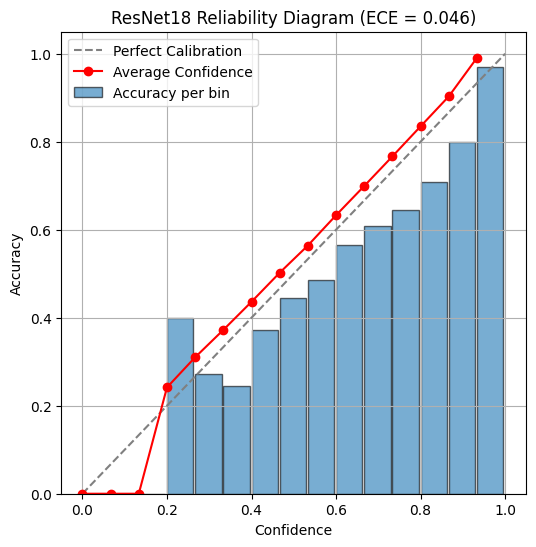

EfficientNet-B0 → ECE = 0.0341


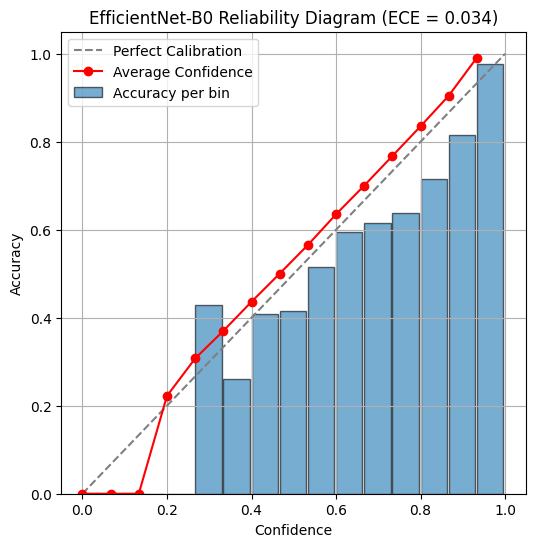

VGG16 → ECE = 0.0330


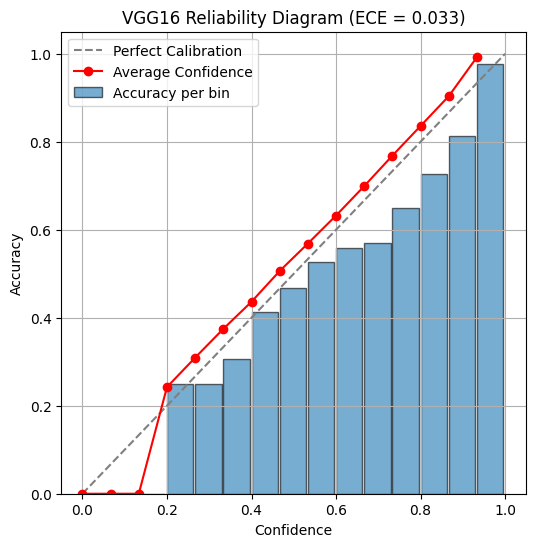


Calibration Summary
ResNet18           | ECE: 0.0456
EfficientNet-B0    | ECE: 0.0341
VGG16              | ECE: 0.0330

 Reliability diagrams displayed above and saved in each model folder.


In [23]:
import numpy as np
import matplotlib.pyplot as plt
import os

def compute_ece(confidences, preds, labels, n_bins=15):
    bins = np.linspace(0.0, 1.0, n_bins + 1)
    ece = 0.0
    bin_accs, bin_confs = [], []

    for i in range(n_bins):
        bin_lower, bin_upper = bins[i], bins[i + 1]
        in_bin = (confidences > bin_lower) & (confidences <= bin_upper)
        prop_in_bin = np.mean(in_bin)
        if prop_in_bin > 0:
            acc_in_bin = np.mean(preds[in_bin] == labels[in_bin])
            avg_conf_in_bin = np.mean(confidences[in_bin])
            ece += np.abs(acc_in_bin - avg_conf_in_bin) * prop_in_bin
            bin_accs.append(acc_in_bin)
            bin_confs.append(avg_conf_in_bin)
        else:
            bin_accs.append(0)
            bin_confs.append(0)
    return ece, bins, bin_accs, bin_confs


def evaluate_model(model_name, base_dir="/kaggle/working/model_results"):
    model_path = os.path.join(base_dir, model_name)
    conf_path = os.path.join(model_path, f"{model_name}_val_confidence.npy")
    preds_path = os.path.join(model_path, f"{model_name}_val_preds.npy")
    labels_path = os.path.join(model_path, f"{model_name}_val_labels.npy")

    confidences = np.load(conf_path)
    preds = np.load(preds_path)
    labels = np.load(labels_path)

    ece, bins, bin_accs, bin_confs = compute_ece(confidences, preds, labels)
    print(f"{model_name} → ECE = {ece:.4f}")

    plt.figure(figsize=(6,6))
    plt.plot([0,1],[0,1],'--', color='gray', label='Perfect Calibration')
    plt.bar(bins[:-1], bin_accs, width=1/len(bins), align='edge', edgecolor='black', alpha=0.6, label='Accuracy per bin')
    plt.plot(bins[:-1], bin_confs, 'o-', color='red', label='Average Confidence')
    plt.xlabel('Confidence')
    plt.ylabel('Accuracy')
    plt.title(f'{model_name} Reliability Diagram (ECE = {ece:.3f})')
    plt.legend()
    plt.grid(True)

    # Save plot
    plot_path = os.path.join(model_path, f"{model_name}_reliability_diagram.png")
    plt.savefig(plot_path, dpi=300, bbox_inches='tight')
    plt.show()   

    # Save ECE value
    with open(os.path.join(model_path, f"{model_name}_ECE.txt"), "w") as f:
        f.write(f"Expected Calibration Error (ECE): {ece:.6f}\n")

    return model_name, ece


models = ["ResNet18", "EfficientNet-B0", "VGG16"]
results = []

for model in models:
    name, ece = evaluate_model(model)
    results.append((name, ece))

print("\nCalibration Summary")
print("="*35)
for name, ece in results:
    print(f"{name:<18} | ECE: {ece:.4f}")
print("="*35)

print("\n Reliability diagrams displayed above and saved in each model folder.")
